In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(edgeitems=20, precision=3, linewidth=160)
import matplotlib.pyplot as plt
fig_width = 12
%matplotlib inline


# the switching binomial generative model


In [2]:
import bayesianchangepoint as bcp

seed = 51 #119 #2017 # 42
np.random.seed(seed)
N_blocks = 3 
N_trials = 800
max_run_length = 350
Jeffreys = False
Jeffreys = True
tau = 40 # N_trials/10.
h = 1./tau
(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)


p0, r0 = .5, 2. - Jeffreys
print('p0, r0 = ', p0, r0)

p0, r0 =  0.5 1.0


## performing inference: application to synthetic data

In [3]:
mode = 'mean'

i_block= 0


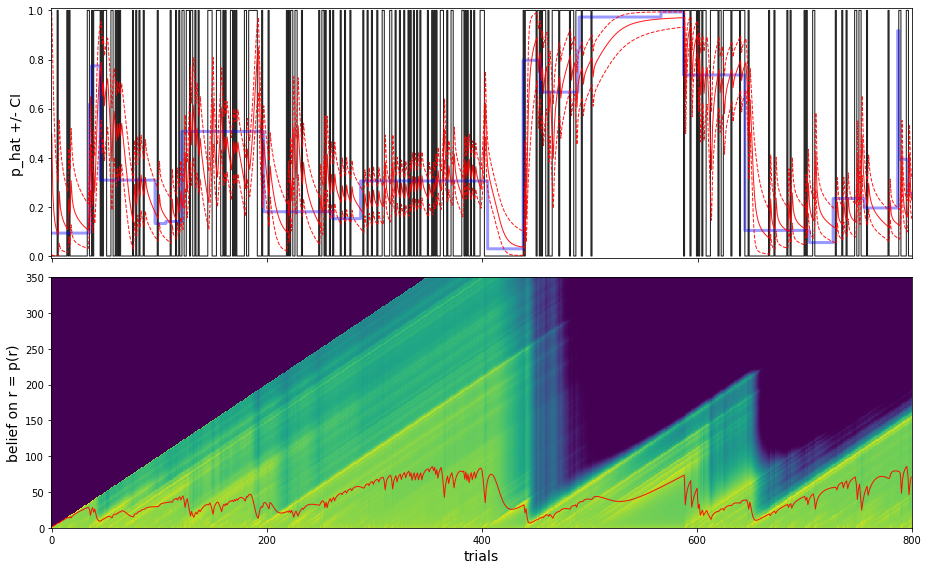

i_block= 1


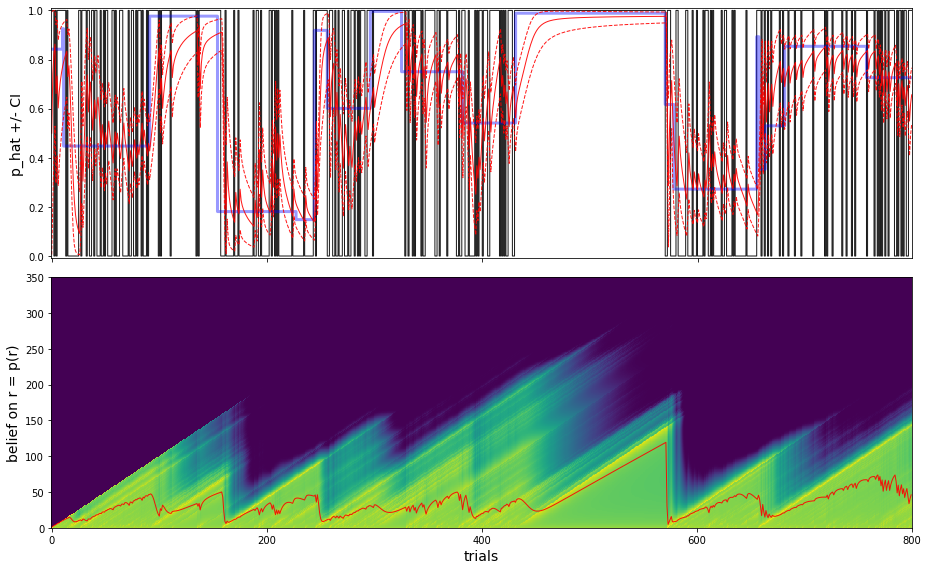

i_block= 2


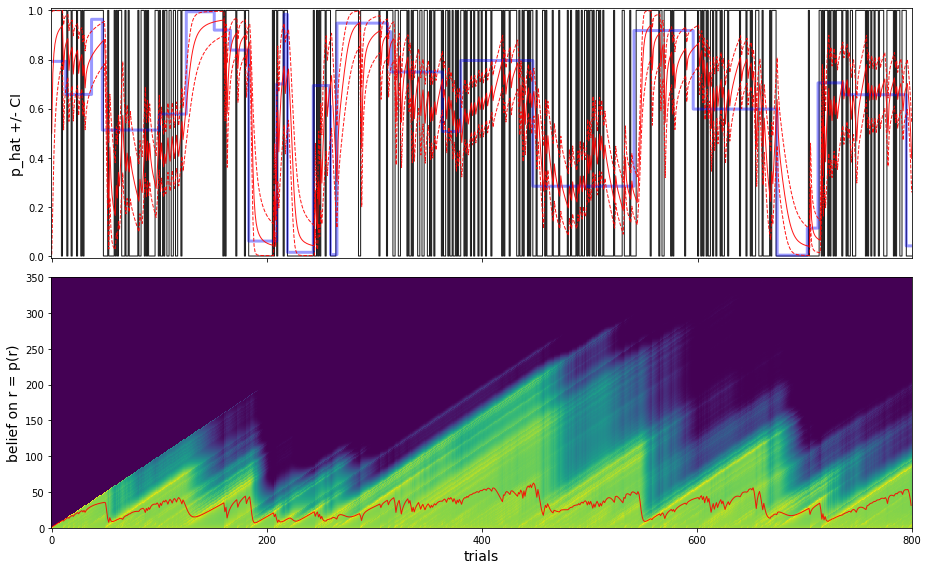

In [4]:
for i_block in range(N_blocks):
    print('i_block=', i_block)
    o = p[:, i_block, 0]
    p_bar, r, beliefs = bcp.inference(o, h=h, p0=p0, r0=r0)
    fig, axs = bcp.plot_inference(p[:, i_block, 0], p[:, i_block, 1], p_bar, r, beliefs, mode=mode, max_run_length=max_run_length)
    plt.show()

## testing different hazard rates: qualitative study

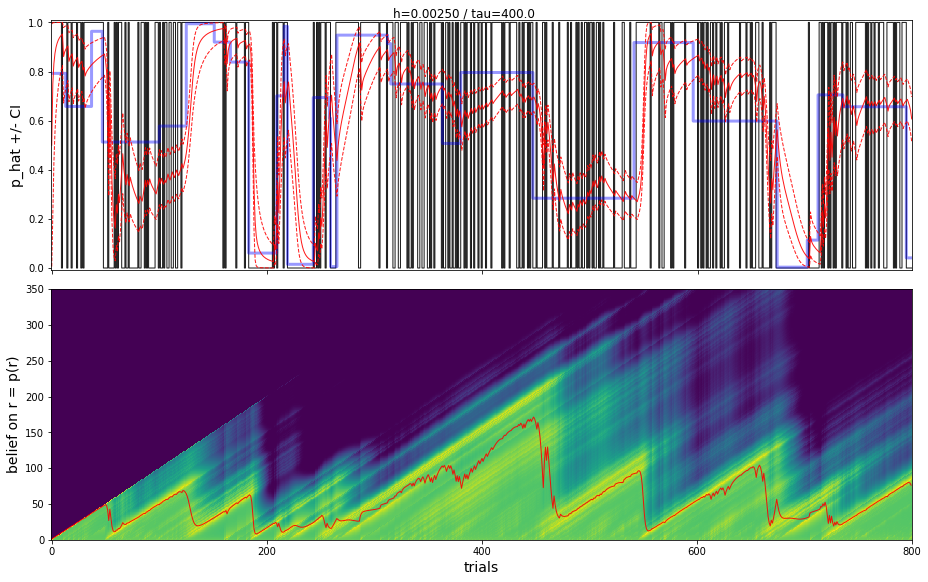

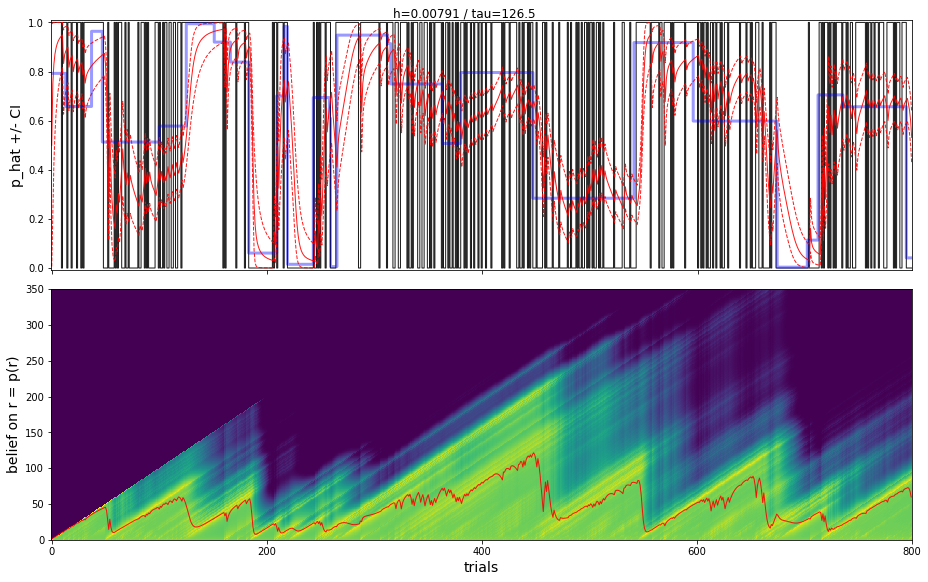

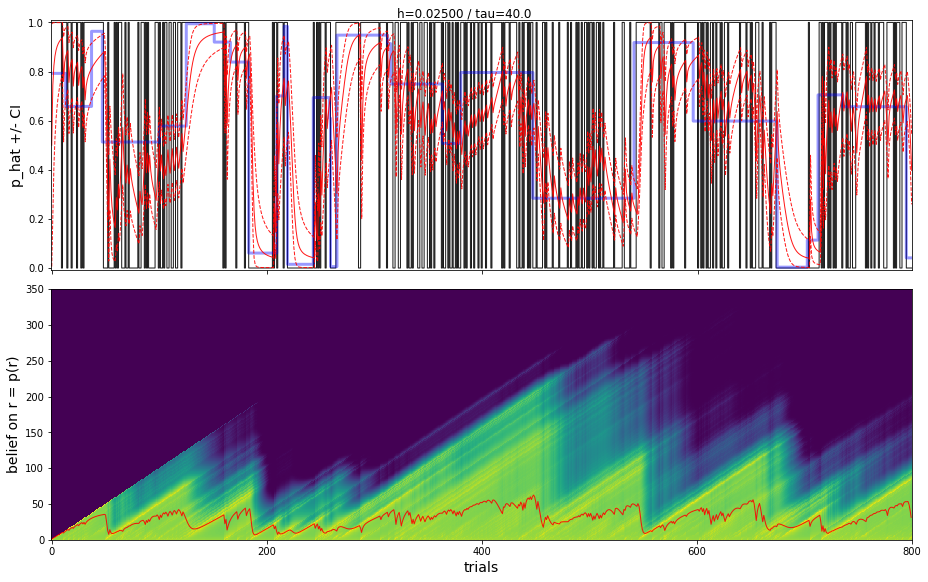

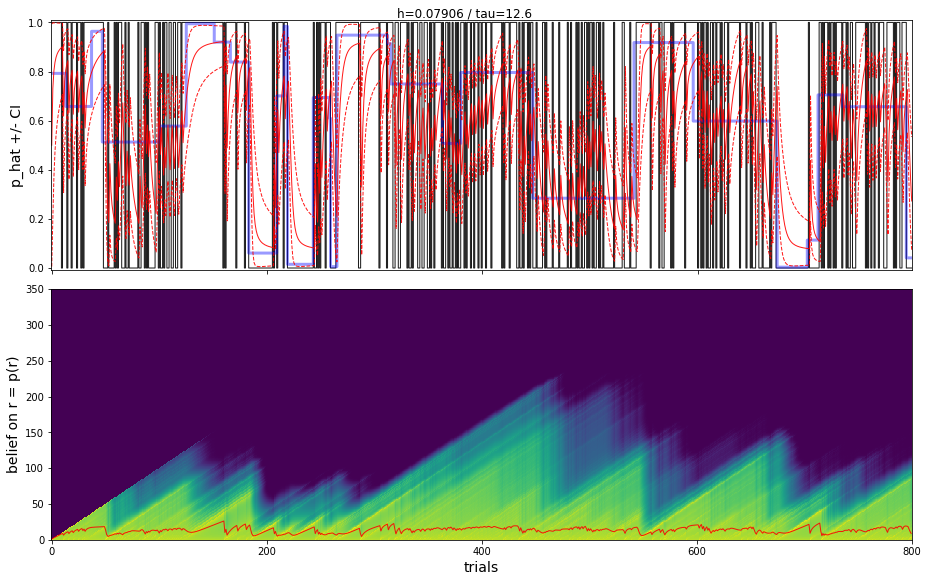

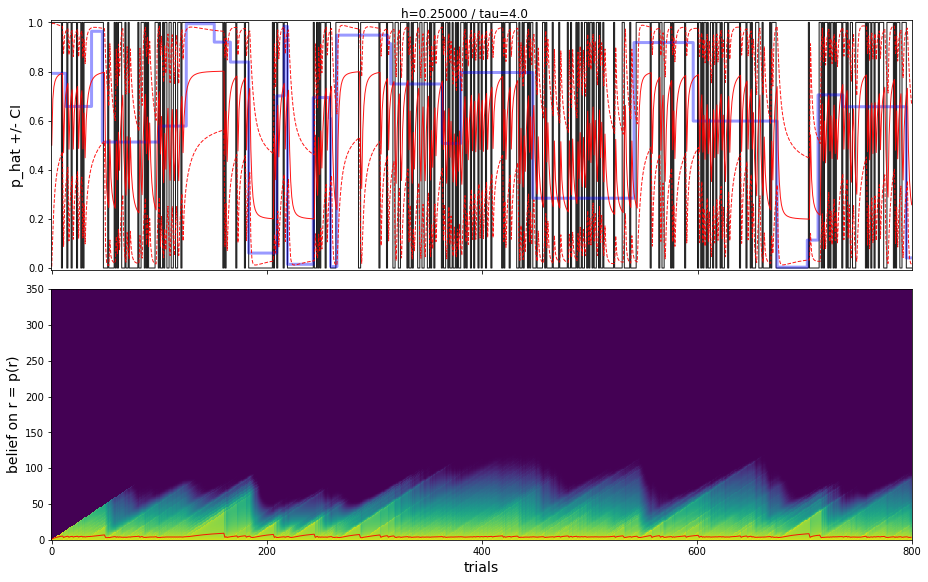

In [5]:
hs = h*np.logspace(-1., 1., 5)
for h_ in hs:
    o = p[:, i_block, 0]
    p_bar, r, beliefs = bcp.inference(o, h=h_, p0=p0, r0=r0)
    fig, axs = bcp.plot_inference(o, p[:, i_block, 1], p_bar, r, beliefs, mode=mode, max_run_length=max_run_length)
    fig.suptitle('h=%.5f' % h_ + ' / tau=%.1f' % (1/h_), y=1)
    plt.show()

## evaluating the best hazard rate using a likelihood score between the predicted bias and the true observations

In [6]:
def KL_distance(p_hat_true, p_hat_agent):
    distance =  - p_hat * np.log2(p_hat_agent) - (1-p_hat) * np.log2(1-p_hat_agent)
    return distance

In [7]:
def KL_distance(p_hat_true, p_hat_agent):
    distance =  - p_hat * np.log2(p_hat_agent) - (1-p_hat) * np.log2(1-p_hat_agent)
    return distance

In [8]:
def KL_distance(p_hat_true, p_hat_agent):
    distance =  -  (p_hat_agent * np.log2(p_hat_true) + (1-p_hat_agent) * np.log2(1-p_hat_true))
    return distance

In [9]:
def pred_score(x_0_true, p_hat_agent):
    score =   (2*x_0_true - 1) * p_hat_agent
    return score

In [10]:
N_scan = 16 # number of h values we test
np.logspace(-2, 1, N_scan, base=2)

array([0.25 , 0.287, 0.33 , 0.379, 0.435, 0.5  , 0.574, 0.66 , 0.758, 0.871, 1.   , 1.149, 1.32 , 1.516, 1.741, 2.   ])

In [20]:
N_blocks = 100 # number of blocks we use in our evaluation

N_trials = 2000

if True: # Debug
    N_blocks = 200 # number of blocks we use in our evaluation
    N_trials = 50 # number of trials in each sub-block


tau = 40 #N_trials/5.
h = 1./tau

modes = ['max', 'mean', 'hindsight', 'fixed']
modes = ['max', 'mean', 'leaky'] # pour le papier
modes = ['expectation', 'max', 'mean', 'hindsight', 'fixed', 'leaky']

border = 2*tau # N_trials//10

(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)

hs = h*np.logspace(-2, 1, N_scan, base=2)
score = np.zeros((len(modes), N_scan, N_blocks))
KL = np.zeros((len(modes), N_scan, N_blocks))
for i_block in range(N_blocks):
    o = p[:, i_block, 0] # observations
    for i_scan, h_ in enumerate(hs):
        p_bar, r, beliefs = bcp.inference(o, h=h_, p0=p0, r0=r0)
        for i_mode, mode_ in enumerate(modes):
            if mode_ in ['fixed', 'leaky']: 
                p_hat_agent, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, fixed_window_size=int(1/h_))
            else:
                p_hat_agent, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, p0=p0)
            #score[i_mode, i_scan, i_block] = np.sum(np.abs(p_hat - p[:, i_block, 0]))
            # score[i_mode, i_scan, i_block] = np.mean(np.log2(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))
            score[i_mode, i_scan, i_block] = np.mean(pred_score(p[:, i_block, 0], p_hat_agent))
            # MI[i_mode, i_delay, i_block] = np.mean(np.log2(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))
            
            #score[i_mode, i_scan, i_block] = np.log2(np.mean(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))
            KL[i_mode, i_scan, i_block] = np.mean(KL_distance(p[:, i_block, 1], p_hat_agent))
            

In [21]:
score.shape, i_mode, np.nanmean(score[i_mode, ...], axis=1)


((6, 9, 200),
 5,
 array([0.154, 0.154, 0.154, 0.155, 0.155, 0.155, 0.156, 0.156, 0.157]))

TODO : evaluate the average gain of the bet by actually drawing a TD from $\hat{x_1}$

### evaluating the best hazard rate using the Mean log-likelihood

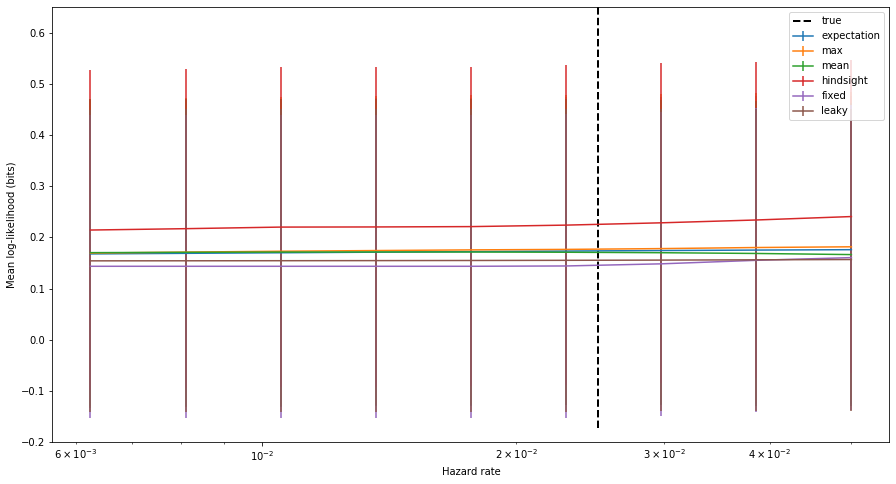

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
for i_mode, mode in enumerate(modes):
    ax.errorbar(hs, np.nanmean(score[i_mode, ...], axis=1), yerr=np.std(score[i_mode, ...], axis=1), label=mode)
ax.vlines(h, ymin=np.nanmin(np.nanmean(score, axis=(0))), ymax=np.nanmax(np.nanmean(score, axis=(0))), 
          linestyle='--', lw=2, label='true')

ax.set_xscale("log")#, nonposx='clip')

ax.set_xlabel('Hazard rate')
ax.set_ylabel('Mean log-likelihood (bits)')
ax.set_ylim(-0.2, 0.65)
ax.legend();

### evaluating the best hazard rate using a KL divergence

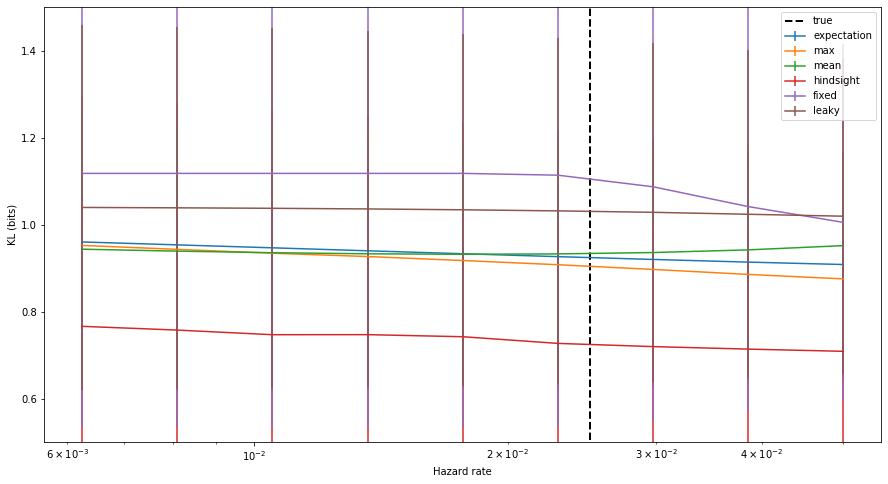

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

for i_mode, mode in enumerate(modes):
    ax.errorbar(hs, np.nanmean(KL[i_mode, ...], axis=1), yerr=np.std(KL[i_mode, ...], axis=1), label=mode)
ax.vlines(h, ymin=np.nanmin(np.nanmean(KL, axis=(0))), ymax=np.nanmax(np.nanmean(KL, axis=(0))), 
          linestyle='--', lw=2, label='true')


ax.set_xscale("log")#, nonposx='clip')

ax.set_xlabel('Hazard rate')
ax.set_ylim(0.5, 1.5)
#ax.set_ylim(0, .5)
ax.set_ylabel('KL (bits)')
ax.legend();

### evaluating the best hazard rate using a KL divergence

In [24]:
p0, r0 = .5, 1.
delays = np.arange(-8, 1)
N_scan = len(delays) # number of h values we test

(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)

score = np.zeros((len(modes), N_scan, N_blocks))
KL = np.zeros((len(modes), N_scan, N_blocks))
for i_delay, delay in enumerate(delays):
    print('delay = ', delay)
    for i_block in range(N_blocks):
        o = p[:, i_block, 0] # observations
        p_bar, r, beliefs = bcp.inference(o, h=h, p0=p0, r0=r0)
        for i_mode, mode_ in enumerate(modes):
            if mode_=='fixed': 
                p_hat_agent, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, fixed_window_size=int(1/h_))
            else:
                p_hat_agent, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, p0=p0)

            p_hat = np.roll(p_hat_agent, delay)
            r_hat = np.roll(r_hat, delay)
            KL[i_mode, i_delay, i_block] = np.mean(KL_distance(p[(border+1):, i_block, 1], p_hat_agent[border:-1]))
            score[i_mode, i_scan, i_block] = np.mean(pred_score(p[(border+1):, i_block, 0], p_hat_agent[border:-1]))
            # MI[i_mode, i_delay, i_block] = np.mean(np.log2(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))
            #score[i_mode, i_scan, i_block] = np.log2(np.mean(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))

delay =  -8


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


delay =  -7
delay =  -6
delay =  -5
delay =  -4
delay =  -3
delay =  -2
delay =  -1
delay =  0


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: All-NaN slice encountered
  if sys.path[0] == '':


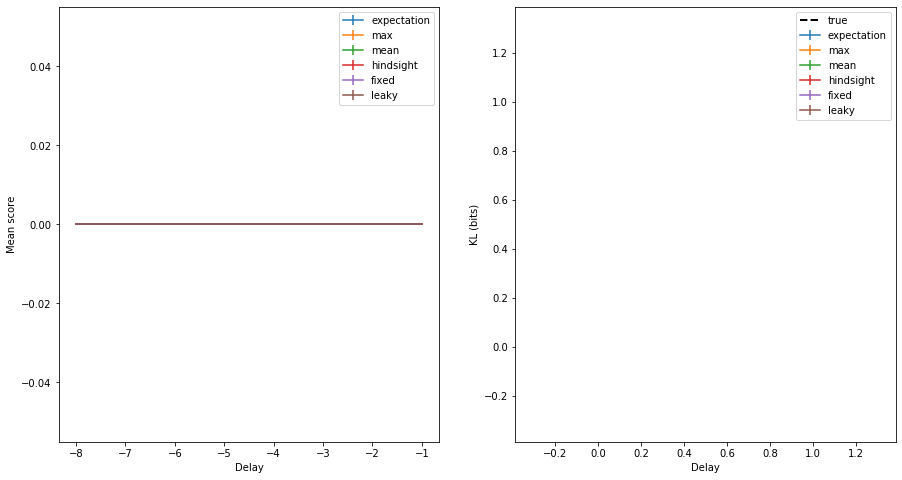

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
for i_mode, mode in enumerate(modes):
    axs[0].errorbar(delays, np.nanmean(score[i_mode, ...], axis=1), yerr=np.std(score[i_mode, ...], axis=1), label=mode)
    
# axs[0].set_ylim(0, .5)
axs[0].set_xlabel('Delay')
axs[0].set_ylabel('Mean score')
axs[0].legend()

for i_mode, mode in enumerate(modes):
    axs[1].errorbar(delays, np.nanmean(KL[i_mode, ...], axis=1), yerr=np.std(KL[i_mode, ...], axis=1), label=mode)
axs[1].vlines(h, ymin=np.nanmin(np.nanmean(KL, axis=(0))), ymax=np.nanmax(np.nanmean(KL, axis=(0))), 
          linestyle='--', lw=2, label='true')

axs[1].set_xlabel('Delay')
#axs[1].set_ylim(0, .5)
axs[1].set_ylabel('KL (bits)')
axs[1].legend();
plt.show()

### what is the influence of the prior's shape?

In [29]:
r0s = [0.1, 0.5, 1, 1.5, 2, 2.5]
N_scan = len(r0s)

(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)

hs = h*np.logspace(-2, 1, N_scan)
score = np.zeros((len(modes), N_scan, N_blocks))
KL = np.zeros((len(modes), N_scan, N_blocks))
for i_r0, r0 in enumerate(r0s):
    print('p0, r0 = ', p0, r0)   
    for i_block in range(N_blocks):
        o = p[:, i_block, 0] # observations
        p_bar, r, beliefs = bcp.inference(o, h=h, p0=p0, r0=r0)
        for i_mode, mode_ in enumerate(modes):
            if mode_=='fixed': 
                p_hat_agent, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, fixed_window_size=int(1/h_))
            else:
                p_hat_agent, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode_, p0=p0)
            KL[i_mode, i_r0, i_block] = np.mean(KL_distance(p[(border+1):, i_block, 1], p_hat_agent[border:-1]))
            score[i_mode, i_scan, i_block] = np.mean(pred_score(p[(border+1):, i_block, 0], p_hat_agent[border:-1]))
            # MI[i_mode, i_delay, i_block] = np.mean(np.log2(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))
            #score[i_mode, i_r0, i_block] = np.mean(np.log2(bcp.likelihood(o[(border+1):], p_hat[border:-1], r_hat[border:-1])))

p0, r0 =  0.5 0.1


IndexError: index 8 is out of bounds for axis 1 with size 6

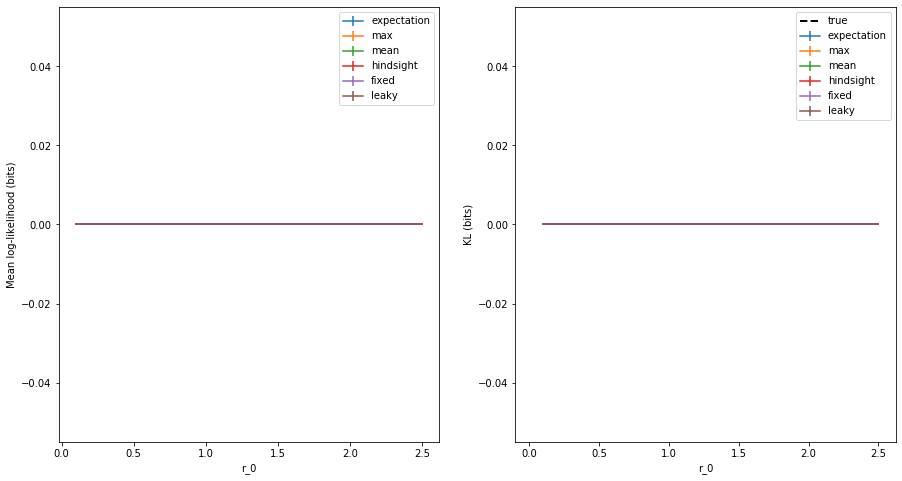

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
for i_mode, mode in enumerate(modes):
    axs[0].errorbar(r0s, np.nanmean(score[i_mode, ...], axis=1), yerr=np.std(score[i_mode, ...], axis=1), label=mode)

# axs[0].set_ylim(0, .5)
axs[0].set_xlabel('r_0')
axs[0].set_ylabel('Mean log-likelihood (bits)')
axs[0].legend()

for i_mode, mode in enumerate(modes):
    axs[1].errorbar(r0s, np.nanmean(KL[i_mode, ...], axis=1), yerr=np.std(KL[i_mode, ...], axis=1), label=mode)
axs[1].vlines(h, ymin=np.nanmin(np.nanmean(KL, axis=(0))), ymax=np.nanmax(np.nanmean(KL, axis=(0))), 
          linestyle='--', lw=2, label='true')

axs[1].set_xlabel('r_0')
#axs[1].set_ylim(0, .5)
axs[1].set_ylabel('KL (bits)')
axs[1].legend();
plt.show()

## evaluating the best hazard rate using a likelihood score between the predicted biases using different values of the hazard rate

Plotting pdf using different hypothesis for h and this for different agents :

In [31]:
p = np.linspace(0, 1, 9)[1:-1]
print('distance(', p, ')=', KL_distance(p, .5))

distance( [0.125 0.25  0.375 0.5   0.625 0.75  0.875] )= [1.596 1.208 1.047 1.    1.047 1.208 1.596]


In [32]:
print('distance(', p, ')=', KL_distance(p, .25))

distance( [0.125 0.25  0.375 0.5   0.625 0.75  0.875] )= [0.894 0.811 0.862 1.    1.231 1.604 2.298]


tau_agent= 20.0 , h_agent=0.050


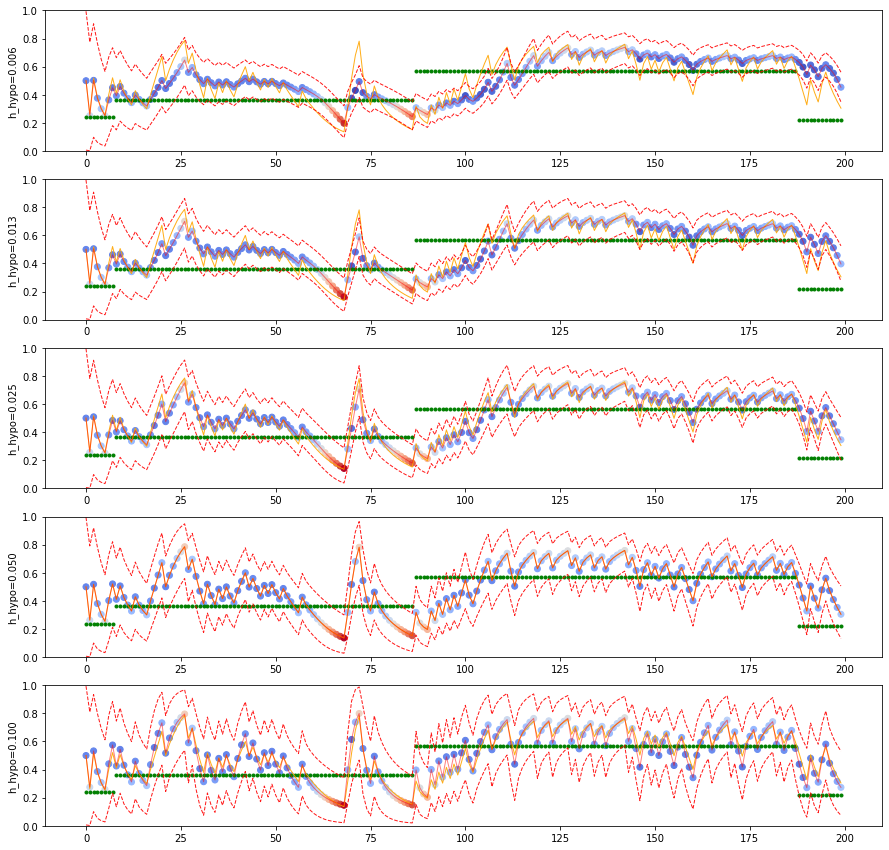

tau_agent= 40.0 , h_agent=0.025


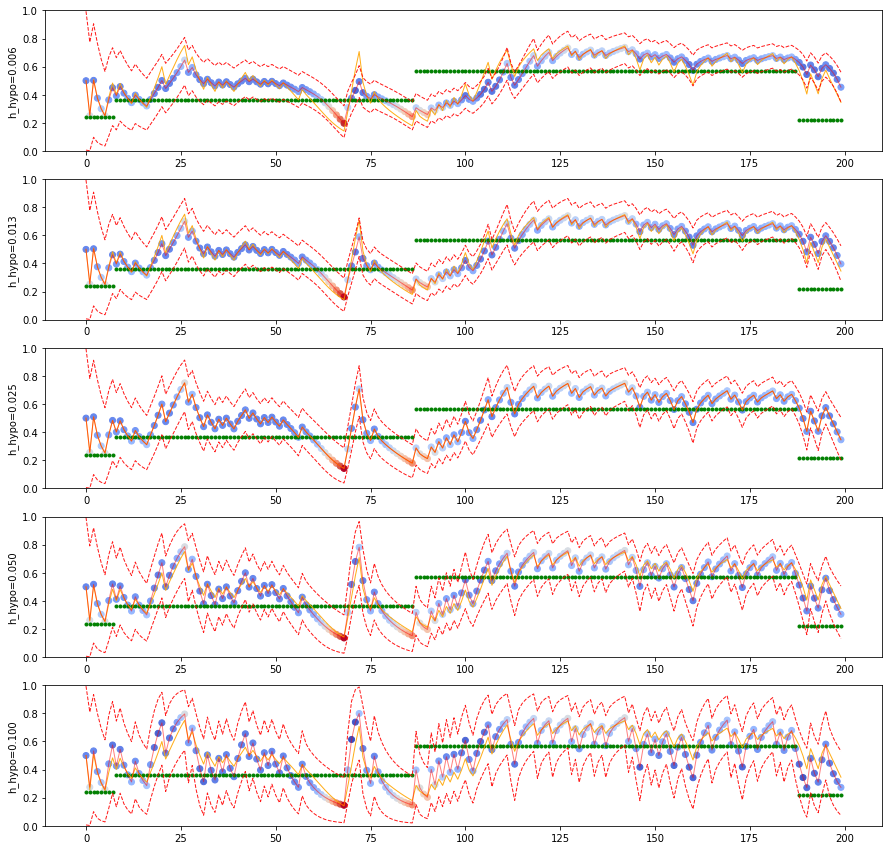

tau_agent= 80.0 , h_agent=0.013


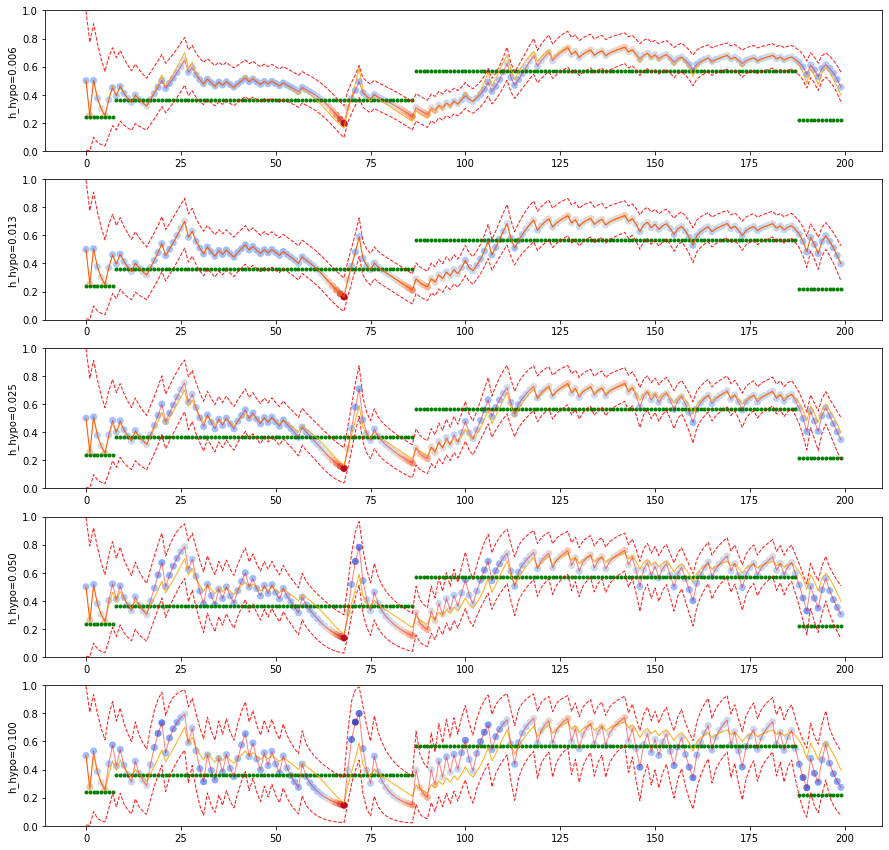

In [33]:
mode = 'mean'
seed = 51 #119 #2017 # 42
np.random.seed(seed)
N_blocks = 1
i_block = 0
Jeffreys = True
tau = 40. # N_trials/10.
h_true = 1./tau
p0, r0 = .5, 2. - Jeffreys
N_trials = 200

# physical world
(trials, p) = bcp.switching_binomial_motion(N_trials=N_trials, N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)

# agents
N_scan = 5
hs = h*np.logspace(-1, 1, N_scan, base=4, endpoint=True)
for tau_agent in [tau/2, tau, tau*2]:
    print('tau_agent=', tau_agent, ', h_agent=%.3f' % (1/tau_agent))
    p_bar_agent, r_agent, beliefs_agent = bcp.inference(p[:, i_block, 0], h=1/tau_agent, p0=p0, r0=r0, verbose=False)
    p_hat_agent, r_hat_agent = bcp.readout(p_bar_agent, r_agent, beliefs_agent, mode=mode, p0=p0)
    
    distance = np.zeros((N_scan, N_trials))
    p_hat = np.zeros((N_scan, N_trials))
    p_low, p_sup = np.zeros_like(distance), np.zeros_like(distance)
    
    for i_scan, h_hypo in enumerate(hs):
        p_bar, r, beliefs = bcp.inference(p[:, i_block, 0], h=h_hypo, p0=p0, r0=r0, verbose=False)
        p_hat[i_scan, :], r_hat = bcp.readout(p_bar, r, beliefs, mode=mode, p0=p0)
        from scipy.stats import beta
        for i_trial in range(N_trials):
            #print('i_trial=%d' % i_trial)
            a = p_hat[i_scan, i_trial]*(r_hat[i_trial])
            b = (1-p_hat[i_scan, i_trial])*(r_hat[i_trial])
            rv = beta(a, b)
            p_low[i_scan, i_trial], p_sup[i_scan, i_trial] = rv.ppf([.05, .95])
            distance[i_scan, i_trial] = KL_distance(p_hat[i_scan, i_trial], p_hat_agent[i_trial])

    distance = np.exp(-distance/np.median(distance))
    fig, axs = plt.subplots(N_scan, 1, figsize=(15, 15))
    for i_scan, h_hypo in enumerate(hs):
        axs[i_scan].plot(trials, p[:, i_block, 1], 'g.', lw=1)
        axs[i_scan].plot(trials, p_hat_agent, c='orange', lw=1, alpha=.9)
        axs[i_scan].plot(trials, p_sup[i_scan, :], 'r--', lw=1, alpha=.9)
        axs[i_scan].plot(trials, p_low[i_scan, :], 'r--', lw=1, alpha=.9)
        axs[i_scan].plot(trials, p_hat[i_scan, :], 'r', lw=1, alpha=.5)
        axs[i_scan].scatter(trials, p_hat[i_scan, :], c=distance[i_scan, :], 
                            vmin=distance.min(), vmax=distance.max(), 
                            alpha=1., cmap=plt.get_cmap('coolwarm'))   
        axs[i_scan].set_ylabel('h_hypo=%.3f' % h_hypo);
        axs[i_scan].set_ylim(0, 1)

    plt.show() 

We can now use the probability computed at each trial to evaluate the likelihood of each hypothesis:

In [37]:
def find_best_h(N_blocks = 200, # number of blocks we use in our evaluation
                N_trials = 50, # number of trials in each sub-block
                N_scan= 15, # number of hypothesis to test
                N_agent= 5 # number of agents we guess h from
               ):
    (trials, p) = bcp.switching_binomial_motion(N_trials=N_trials,
                                                N_blocks=N_blocks, tau=tau, seed=seed, Jeffreys=Jeffreys)

    h_agents = h*np.logspace(-1, 1, N_agent, base=2, endpoint=True)
    hs = h*np.logspace(-1, 1, N_scan, base=4)

    fig, axs = plt.subplots(1, N_agent, figsize=(15, 8))

    for i_agent, h_agent in enumerate(h_agents):
        distance = np.zeros((N_scan, N_blocks))
        for i_block in range(N_blocks):

            p_bar, r, beliefs = bcp.inference(
                p[:, i_block, 0], h=h_agent, p0=p0, r0=r0, verbose=False)
            p_hat_agent, r_hat_agent = bcp.readout(
                p_bar, r, beliefs, mode=mode, p0=p0)

            for i_scan, h_ in enumerate(hs):
                p_bar, r, beliefs = bcp.inference(
                    p[:, i_block, 0], h=h_, p0=p0, r0=r0, verbose=False)
                p_hat, r_hat = bcp.readout(p_bar, r, beliefs, mode=mode, p0=p0)
                distance_ = KL_distance(p_hat, p_hat_agent) 

                distance[i_scan, i_block] = np.mean(distance_)
        axs[i_agent].errorbar(hs, np.nanmean(distance, axis=1), yerr=np.std(distance, axis=1))
        axs[i_agent].vlines(h_agent, ymin=np.nanmin(distance), ymax=np.nanmax(distance),
                            colors='b', linestyle='--', lw=2, label='h_agent=%.3f' % h_agent)
        h_opt = hs[np.argmin(np.mean(distance, axis=1))]
        axs[i_agent].vlines(h_opt, ymin=np.nanmin(distance), ymax=np.nanmax(distance),
                            colors='r', linestyle='--', lw=2, label='h_opt=%.3f' % h_opt)
        axs[i_agent].set_xscale("log")#, nonposx='clip')
        #axs[i_agent].set_ylim(0)
        axs[i_agent].set_xlabel('Hazard rate')
        axs[i_agent].legend(loc='best')
    axs[0].set_ylabel('distance')
    return fig, axs

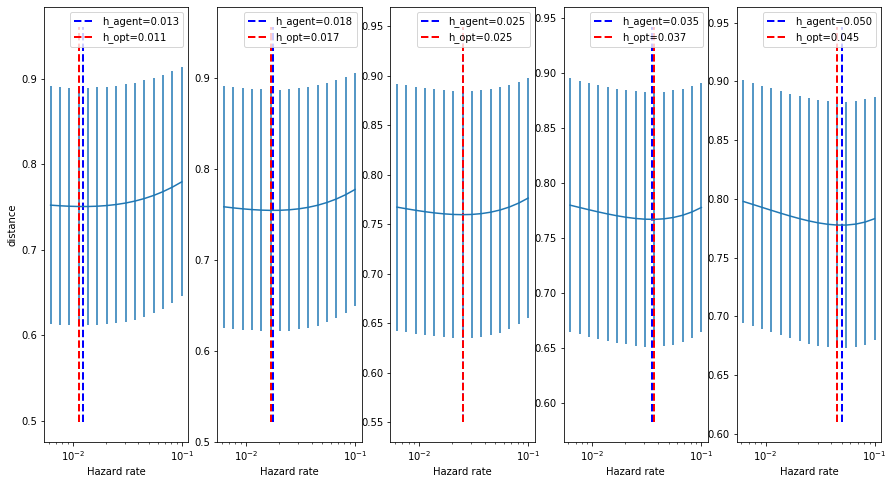

In [38]:
fig, axs = find_best_h(N_blocks = 20, N_trials = 50)
plt.show()

Note that longer blocks give results closer to the true value (there is less variability in distance):

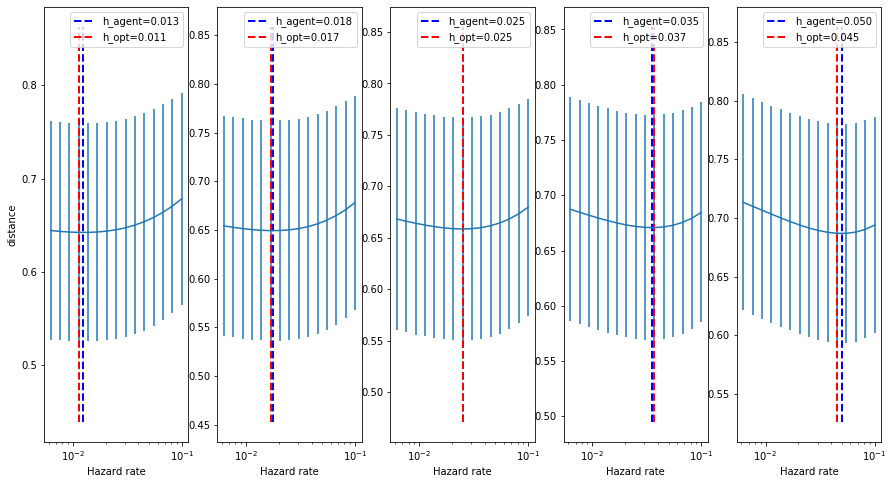

In [39]:
fig, axs = find_best_h(N_blocks = 20, N_trials = 500)